# Fase 1: Importación de librerías necesarias

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ------------------------------
# MÓDULOS PARA MANIPULACIÓN Y VISUALIZACIÓN DE DATOS
# ------------------------------
import numpy as np  # Operaciones numéricas de alto rendimiento
import pandas as pd  # Manipulación de datos estructurados (opcional si se usa DataFrame)
import matplotlib.pyplot as plt  # Visualización de métricas y resultados
import seaborn as sns  # Visualizaciones más atractivas
import re

# ------------------------------
# MÓDULOS DE PREPROCESAMIENTO Y UTILIDADES DE KERAS
# ------------------------------
from tensorflow.keras.datasets import imdb  # Dataset IMDB preprocesado de Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Padding para secuencias
from tensorflow.keras.preprocessing.text import Tokenizer  # (Si decides usar texto original en lugar de índices)
# ------------------------------
# MÓDULOS PARA DEFINIR EL MODELO EN KERAS
# ------------------------------
from tensorflow.keras.models import Model  # API funcional para modelos complejos
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, Add, Embedding
# ------------------------------
# MÓDULOS DE LA ARQUITECTURA TRANSFORMER (capas de atención y más)
# ------------------------------
from tensorflow.keras.layers import MultiHeadAttention  # Mecanismo de atención multiparte
from tensorflow.keras.optimizers import Adam  # Optimizador popular en NLP
from tensorflow.keras.losses import BinaryCrossentropy  # Pérdida para clasificación binaria
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard, Callback
# ------------------------------
# MÓDULOS PARA MÉTRICAS Y ANÁLISIS
# ------------------------------
from sklearn.metrics import classification_report, confusion_matrix  # Métricas de rendimiento
from sklearn.model_selection import train_test_split
# ------------------------------
# UTILIDADES ADICIONALES
# ------------------------------
import tensorflow as tf  # Librería base para modelos de deep learning
import os  # Para gestionar rutas de guardado de modelos/logs

# Fase 2: Exploración del Dataset IMDB

In [ ]:
# Cargamos el dataset IMDB desde Keras.
# Este dataset ya viene tokenizado: las palabras han sido reemplazadas por índices enteros.
# num_words=10000 indica que se conservarán las 10,000 palabras más frecuentes.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Revisamos la cantidad de muestras en entrenamiento y prueba
print("Tamaño del set de entrenamiento:", len(X_train))
print("Tamaño del set de prueba:", len(X_test))

Tamaño del set de entrenamiento: 25000
Tamaño del set de prueba: 25000


In [ ]:
# Mostramos una reseña en su forma tokenizada (índices de palabras)
print("Ejemplo de reseña (tokenizada):", X_train[0])

# Mostramos la etiqueta asociada (0 = negativa, 1 = positiva)
print("Etiqueta de la reseña:", y_train[0])

Ejemplo de reseña (tokenizada): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
Etiqueta de la reseña: 1


In [ ]:
# Calculamos la longitud de cada reseña
review_lengths = [len(review) for review in X_train]

# Estadísticas descriptivas sobre la longitud de las reseñas
print("Longitud mínima:", np.min(review_lengths))
print("Longitud máxima:", np.max(review_lengths))
print("Longitud promedio:", np.mean(review_lengths))

Longitud mínima: 11
Longitud máxima: 2494
Longitud promedio: 238.71364


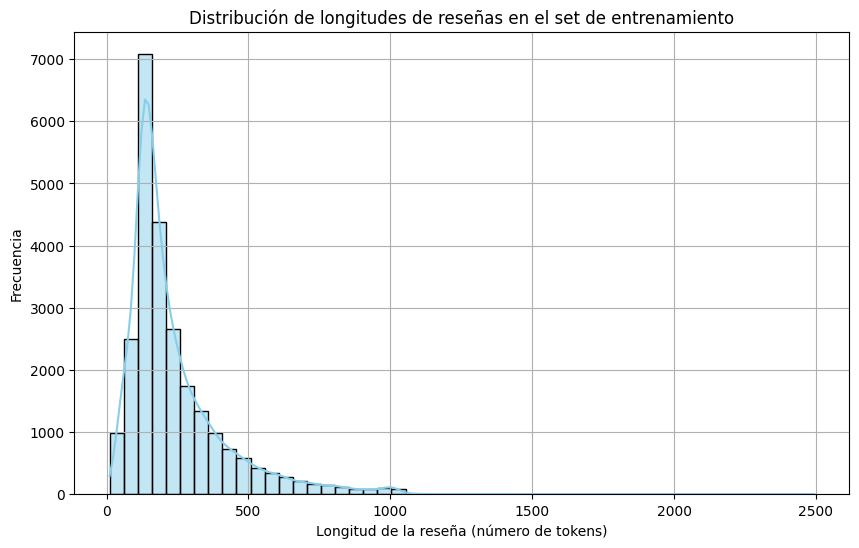

In [ ]:
# Visualizamos la distribución de las longitudes para decidir un valor razonable de padding
plt.figure(figsize=(10, 6))
sns.histplot(review_lengths, bins=50, kde=True, color='skyblue')
plt.title("Distribución de longitudes de reseñas en el set de entrenamiento")
plt.xlabel("Longitud de la reseña (número de tokens)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

In [ ]:
# Obtenemos el diccionario que mapea palabras a índices
word_index = imdb.get_word_index()

# Revertimos el diccionario: de índice a palabra
index_to_word = {index + 3: word for word, index in word_index.items()}
index_to_word[0] = "[PAD]"
index_to_word[1] = "[START]"
index_to_word[2] = "[UNK]"
index_to_word[3] = "[UNUSED]"

# Función para decodificar una reseña
def decode_review(encoded_review):
    return ' '.join([index_to_word.get(i, "?") for i in encoded_review])

# Visualizamos la reseña decodificada
print("Reseña decodificada:\n", decode_review(X_train[0]))

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Reseña decodificada:
 [START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [UNK] is an amazing actor and now the same being director [UNK] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [UNK] and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [UNK] to the two little boy's that played the [UNK] of norman and paul they were just brilliant children are often left out of the [UNK] list i think because the stars that play them all grown up are such a big profile for the 

# Fase 3: Preprocesamiento del Dataset IMDB

Paso 1: Definir la longitud máxima de las secuencias

In [ ]:
# Longitud máxima de las reseñas para padding/truncamiento
MAX_LEN = 250  # Puedes ajustarlo si quieres probar con más/menos contexto

Paso 2: Aplicar padding a las secuencias

In [ ]:
# Pad o trunca las reseñas para que todas tengan la misma longitud
X_train_pad = pad_sequences(X_train, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test, maxlen=MAX_LEN, padding='post', truncating='post')

# Verificamos que todas las reseñas ahora tengan la misma longitud
print("Nueva forma de las reseñas:", X_train_pad.shape)

Nueva forma de las reseñas: (25000, 250)


Paso 3: Conversión de etiquetas a float32

In [ ]:
# Convertimos las etiquetas a float32 para compatibilidad con la función de pérdida
y_train = np.array(y_train).astype("float32")
y_test = np.array(y_test).astype("float32")

Paso 4: Crear un conjunto de validación

In [ ]:
# Separamos un pequeño conjunto de validación del set de entrenamiento
X_train_pad, X_val_pad, y_train, y_val = train_test_split(
    X_train_pad, y_train, test_size=0.15, random_state=42)

print("Train shape:", X_train_pad.shape)
print("Validation shape:", X_val_pad.shape)

Train shape: (21250, 250)
Validation shape: (3750, 250)


Paso 5: Revisar una reseña tras el padding

In [ ]:
# Mostrar la reseña decodificada después del padding
print("Reseña con padding:\n", decode_review(X_train_pad[0]))

Reseña con padding:
 [START] i love buying those cheap lousy dvd's from [UNK] video one day i happened to buy this one it's the perfect silly science fiction film of the 50's all [UNK] up [UNK] with [UNK] everything scantily clad girls and plenty of melodrama it's an enjoyable film to those who appreciate this kind of stuff and if you can [UNK] your [UNK] enough you can actually get [UNK] out not just by the psychotic head or by the beating of the thing in the closet but toward the end with the character of 'the perfect [UNK] it's so what's another word for [UNK] ing [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

## 3.1 Validación de los Datos Procesados

1. Verificar la distribución de clases (positivas vs negativas)

Negativa: 10686 muestras
Positiva: 10564 muestras


/tmp/ipython-input-14-90149018.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette='viridis')


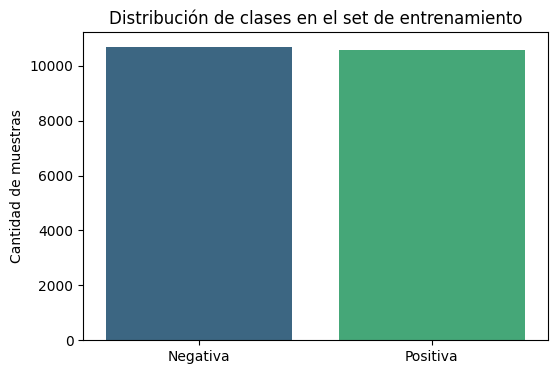

In [ ]:
# Conteo de clases en el set de entrenamiento
unique, counts = np.unique(y_train, return_counts=True)

# Mapeo a etiquetas legibles
labels = ['Negativa', 'Positiva']
for label, count in zip(labels, counts):
    print(f"{label}: {count} muestras")

# Visualización con gráfico de barras
plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=counts, palette='viridis')
plt.title("Distribución de clases en el set de entrenamiento")
plt.ylabel("Cantidad de muestras")
plt.show()

2. Confirmar que todas las secuencias tengan el mismo largo

In [ ]:
# Verificamos que todas las secuencias sean de longitud MAX_LEN
train_lengths = [len(seq) for seq in X_train_pad]
print("¿Todas las reseñas tienen longitud MAX_LEN?:", all(l == MAX_LEN for l in train_lengths))

¿Todas las reseñas tienen longitud MAX_LEN?: True


3. Mostrar un ejemplo post-padding y su etiqueta

In [ ]:
# Seleccionamos una reseña y mostramos su contenido
idx = 1
print("Etiqueta:", "Positiva" if y_train[idx] == 1.0 else "Negativa")
print("Secuencia tokenizada (con padding):\n", X_train_pad[idx])

# Decodificamos (excluyendo ceros del padding para mayor claridad)
print("Reseña decodificada:\n", decode_review([i for i in X_train_pad[idx] if i != 0]))

Etiqueta: Negativa
Secuencia tokenizada (con padding):
 [   1   48   13 1869  332   27  403   23    4  288 1108   13  115   62
   28 6677   15   14  247    2    5  154 3357  621   16   93   34    6
  132   38 3280 3445   19    4  785  162 2869   11  192    4   22    9
   38  230   39   15   15   13  594   48  145   11    4 4867    5 3352
  162 2869    2   62   28  427 1800   14  552    7   22   45   38   38
 4928    5   12  186    8   28  117    8   81   19   38  111    7   27
  960  108   14  218 2707    6   78  155   43    6   55 1767  155   10
   10   51   13   82  258    6  227 1767   16    4 1166    7 2822   49
    7    4 1989  520   14   22  262   54   50   26   38  111  128  785
 2769   46   50    4  690   11   14   22   71  331   24  572  221    5
    4  105   32  468   38 1904    5 2749   48   13   69    8   67  160
 1026  415   37    2   44   89  254   12    9    8   30 1026   42   79
    6   52 6388 1866   23    6 5417 4267   13   16  170    8    2   10
   10    4 1324  347 

4. Comprobar distribución de clases en validación y test

In [ ]:
# Validación
val_labels, val_counts = np.unique(y_val, return_counts=True)
print("Distribución en Validación:", dict(zip(val_labels, val_counts)))

# Test
test_labels, test_counts = np.unique(y_test, return_counts=True)
print("Distribución en Test:", dict(zip(test_labels, test_counts)))

Distribución en Validación: {np.float32(0.0): np.int64(1814), np.float32(1.0): np.int64(1936)}
Distribución en Test: {np.float32(0.0): np.int64(12500), np.float32(1.0): np.int64(12500)}


5. Confirmar tipos y dimensiones finales

In [ ]:
print("Tipo de datos de X_train_pad:", X_train_pad.dtype)
print("Forma de X_train_pad:", X_train_pad.shape)
print("Forma de y_train:", y_train.shape)

Tipo de datos de X_train_pad: int32
Forma de X_train_pad: (21250, 250)
Forma de y_train: (21250,)


# Fase 4: Diseño del Modelo Transformer Encoder-Decoder

In [ ]:
# Dimensiones del modelo Transformer
VOCAB_SIZE = 10000        # Número de palabras únicas
MAX_LEN = 250             # Longitud máxima de las secuencias (ya definido)
EMBED_DIM = 128           # Dimensión del embedding
NUM_HEADS = 4             # Número de cabezas de atención
FF_DIM = 128              # Dimensión interna del feed-forward
NUM_ENCODER_BLOCKS = 2    # Número de bloques en el encoder
NUM_DECODER_BLOCKS = 2    # Número de bloques en el decoder
DROPOUT_RATE = 0.1

In [ ]:
# Capa de embedding con mask_zero=True para soportar padding
embedding_layer = Embedding(input_dim=VOCAB_SIZE,
                            output_dim=EMBED_DIM,
                            input_length=MAX_LEN,
                            mask_zero=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Bloque del encoder
def transformer_encoder(inputs):
    # Multi-head self-attention
    attention = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)(inputs, inputs)
    attention = Dropout(DROPOUT_RATE)(attention)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attention)

    # Feed-forward
    ff = Dense(FF_DIM, activation="relu")(out1)
    ff = Dense(EMBED_DIM)(ff)
    ff = Dropout(DROPOUT_RATE)(ff)
    return LayerNormalization(epsilon=1e-6)(out1 + ff)

# Bloque del decoder (simplificado para clasificación)
def transformer_decoder(inputs, encoder_output):
    # Masked self-attention del decoder
    attention1 = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)(inputs, inputs)
    attention1 = Dropout(DROPOUT_RATE)(attention1)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attention1)

    # Atención sobre la salida del encoder
    attention2 = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)(out1, encoder_output)
    attention2 = Dropout(DROPOUT_RATE)(attention2)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + attention2)

    # Feed-forward
    ff = Dense(FF_DIM, activation="relu")(out2)
    ff = Dense(EMBED_DIM)(ff)
    ff = Dropout(DROPOUT_RATE)(ff)
    return LayerNormalization(epsilon=1e-6)(out2 + ff)

In [ ]:
# Input del encoder y decoder
encoder_inputs = Input(shape=(MAX_LEN,), name="encoder_input")
decoder_inputs = Input(shape=(MAX_LEN,), name="decoder_input")

# Embedding compartido para encoder y decoder
x_enc = embedding_layer(encoder_inputs)
x_dec = embedding_layer(decoder_inputs)

# Aplicamos bloques encoder
for _ in range(NUM_ENCODER_BLOCKS):
    x_enc = transformer_encoder(x_enc)

# Aplicamos bloques decoder
for _ in range(NUM_DECODER_BLOCKS):
    x_dec = transformer_decoder(x_dec, x_enc)

# Pooling + Capa de salida
x = GlobalAveragePooling1D()(x_dec)
x = Dropout(DROPOUT_RATE)(x)
outputs = Dense(1, activation="sigmoid")(x)

# Modelo final
transformer_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)

In [ ]:
# Resumen del modelo
transformer_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_input       │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 250, 128)  │  1,280,000 │ encoder_input[0]… │
│ (Embedding)         │                   │            │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 250)       │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 250, 128)  │    263,808 │ embedding[0][0],  │
│ (MultiHeadAttentio… │                   │            │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 250, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 250, 128)  │          0 │ embedding[0][0],  │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 250, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 250, 128)  │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 250, 128)  │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 250, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 250, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 250, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 250, 128)  │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 250, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 250, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 250, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 250)       │          0 │ decoder_input[0]

 Total params: 2,997,633 (11.44 MB)

 Trainable params: 2,997,633 (11.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
transformer_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),
    metrics=["accuracy"]
)

# Fase 5: Entrenamiento del Modelo Transformer

In [ ]:
# Rutas definidas
CHECKPOINT_DIR = "/content/drive/MyDrive/Transformer/Checkpoint"
LOG_DIR = "/content/drive/MyDrive/Transformer/Log"
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "best_model.h5")
EPOCH_TRACKER_PATH = os.path.join(CHECKPOINT_DIR, "last_epoch.txt")

In [ ]:
# ⚠️ Validación robusta de existencia y contenido
def is_checkpoint_valid(model_path):
    return os.path.isfile(model_path) and os.path.getsize(model_path) > 0

def is_epoch_file_valid(epoch_path):
    return os.path.isfile(epoch_path) and os.path.getsize(epoch_path) > 0

# Epoch inicial
initial_epoch = 0

# Cargar pesos si ambos archivos son válidos
if is_checkpoint_valid(CHECKPOINT_PATH) and is_epoch_file_valid(EPOCH_TRACKER_PATH):
    try:
        print("✅ Checkpoint encontrado. Intentando cargar pesos del modelo...")
        transformer_model.load_weights(CHECKPOINT_PATH)
        with open(EPOCH_TRACKER_PATH, "r") as f:
            initial_epoch = int(f.read().strip()) + 1
        print(f"Reanudando desde la época {initial_epoch}")
    except Exception as e:
        print("⚠️ Error al cargar los pesos del checkpoint. Se ignorará y se entrenará desde cero.")
        print(f"Detalles del error: {e}")
        initial_epoch = 0
else:
    print("ℹ️ No se encontró checkpoint válido. Entrenamiento comenzará desde la época 0.")

ℹ️ No se encontró checkpoint válido. Entrenamiento comenzará desde la época 0.


In [ ]:
# Callback personalizado para guardar el número de la última época completada
class EpochTrackerCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        with open(EPOCH_TRACKER_PATH, "w") as f:
            f.write(str(epoch))

callbacks = [
    EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint(
        filepath=CHECKPOINT_PATH,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    TensorBoard(log_dir=LOG_DIR),
    EpochTrackerCallback()
]

In [ ]:
history = transformer_model.fit(
    [X_train_pad, X_train_pad],   # input_encoder, input_decoder
    y_train,
    validation_data=([X_val_pad, X_val_pad], y_val),
    epochs=60,
    initial_epoch=initial_epoch,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/60
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6553 - loss: 0.5878
Epoch 1: val_loss improved from inf to 0.34477, saving model to /content/drive/MyDrive/Transformer/Checkpoint/best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 96s 205ms/step - accuracy: 0.6556 - loss: 0.5874 - val_accuracy: 0.8509 - val_loss: 0.3448 - learning_rate: 1.0000e-04
Epoch 2/60
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9009 - loss: 0.2524
Epoch 2: val_loss improved from 0.34477 to 0.31059, saving model to /content/drive/MyDrive/Transformer/Checkpoint/best_model.h5


333/333 ━━━━━━━━━━━━━━━━━━━━ 115s 167ms/step - accuracy: 0.9009 - loss: 0.2524 - val_accuracy: 0.8688 - val_loss: 0.3106 - learning_rate: 1.0000e-04
Epoch 3/60
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9324 - loss: 0.1841
Epoch 3: val_loss did not improve from 0.31059
333/333 ━━━━━━━━━━━━━━━━━━━━ 80s 163ms/step - accuracy: 0.9324 - loss: 0.1842 - val_accuracy: 0.8707 - val_loss: 0.3344 - learning_rate: 1.0000e-04
Epoch 4/60
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9523 - loss: 0.1377
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 4: val_loss did not improve from 0.31059
333/333 ━━━━━━━━━━━━━━━━━━━━ 84s 170ms/step - accuracy: 0.9523 - loss: 0.1377 - val_accuracy: 0.8440 - val_loss: 0.4359 - learning_rate: 1.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


# Fase 6: Evaluación del Modelo

In [ ]:
# Cargar los mejores pesos del entrenamiento
transformer_model.load_weights("/content/drive/MyDrive/Transformer/Checkpoint/best_model.h5")
print("✅ Pesos del mejor modelo cargados exitosamente.")

✅ Pesos del mejor modelo cargados exitosamente.


In [ ]:
# Evaluación del modelo en el conjunto de test
test_loss, test_accuracy = transformer_model.evaluate([X_test_pad, X_test_pad], y_test, verbose=1)
print(f"📊 Evaluación en test - Accuracy: {test_accuracy:.4f} | Loss: {test_loss:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.8571 - loss: 0.3339
📊 Evaluación en test - Accuracy: 0.8578 | Loss: 0.3344


782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step
📋 Reporte de Clasificación:

              precision    recall  f1-score   support

    Negativa       0.82      0.91      0.86     12500
    Positiva       0.90      0.81      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



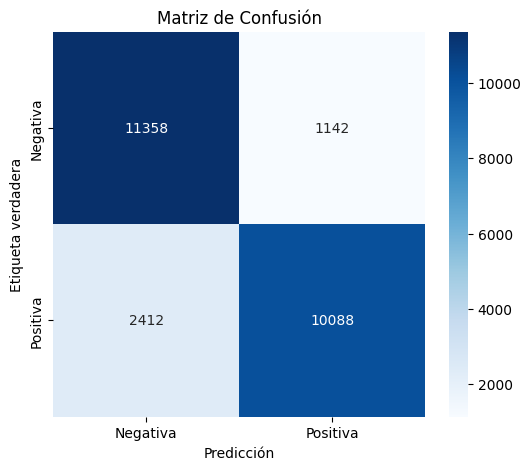

In [ ]:
# Predicciones (probabilidades)
y_pred_prob = transformer_model.predict([X_test_pad, X_test_pad])
# Convertir a clases (0 o 1)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Reporte de clasificación
print("📋 Reporte de Clasificación:\n")
print(classification_report(y_test, y_pred, target_names=["Negativa", "Positiva"]))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualización
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negativa", "Positiva"], yticklabels=["Negativa", "Positiva"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.title("Matriz de Confusión")
plt.show()

/tmp/ipython-input-32-2417583913.py:11: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


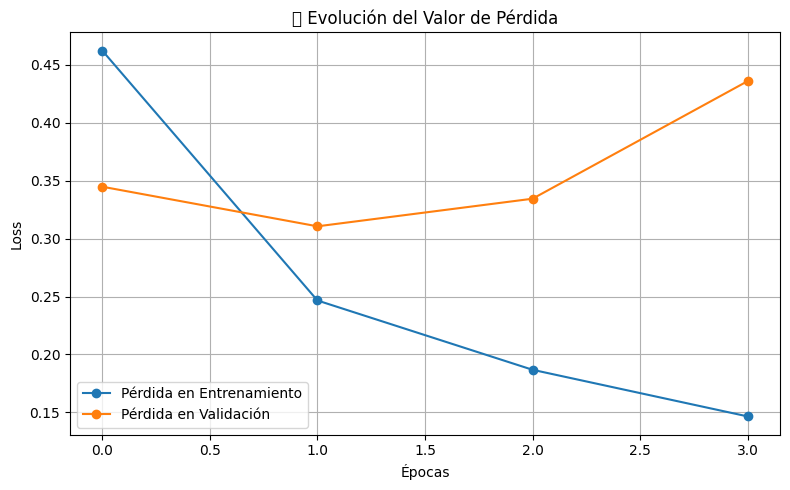

In [ ]:
# Gráfico del valor de pérdida durante el entrenamiento
def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Pérdida en Entrenamiento', marker='o')
    plt.plot(history.history['val_loss'], label='Pérdida en Validación', marker='o')
    plt.title('📉 Evolución del Valor de Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Llamamos a la función
plot_loss(history)

In [ ]:
# Si estás en Google Colab, ejecuta esta celda para cargar el tablero de TensorBoard
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Transformer/Log

<IPython.core.display.Javascript object>

# Fase 7 predicciones

In [ ]:
# Reconstruye el modelo exactamente igual que durante el entrenamiento
# (con los bloques encoder, decoder, embeddings, pooling y demás definidos)

transformer_model.load_weights("/content/drive/MyDrive/Transformer/Checkpoint/best_model.h5")
print("✅ Modelo cargado correctamente.")

✅ Modelo cargado correctamente.


In [ ]:
sample_reviews = [
    "This movie was a masterpiece with stunning visuals and strong performances",
    "Absolutely terrible. I can't believe I wasted two hours on this",
    "It was okay, not bad but not great either",
    "One of the best films I've seen in years!",
    "The plot made no sense and the acting was wooden",
    "I laughed, I cried, and I loved every minute of it",
    "Completely overrated. Don't understand the hype",
    "An emotional rollercoaster with brilliant writing",
    "Boring and predictable from start to finish",
    "This is a bad movie"
]

In [ ]:
# Cargar diccionario de palabras
word_index = imdb.get_word_index()
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["[PAD]"] = 0
word_index["[START]"] = 1
word_index["[UNK]"] = 2
word_index["[UNUSED]"] = 3

def encode_review(text, max_len=250):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    tokens = text.split()
    encoded = [1]  # [START]
    for word in tokens:
        encoded.append(word_index.get(word, 2))
    padded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    return padded

In [ ]:
print("🔍 PREDICCIONES DETALLADAS DEL MODELO TRANSFORMER:\n")

for i, review in enumerate(sample_reviews):
    encoded = encode_review(review, max_len=250)
    prediction = transformer_model.predict([encoded, encoded])[0][0]
    predicted_class = int(prediction >= 0.5)

    predicted_sentiment = "Positiva ✅" if predicted_class == 1 else "Negativa ❌"
    probability_percent = prediction * 100  # Convertimos a porcentaje

    print(f"{i+1}. Reseña: \"{review}\"\n")
    print(f"   🟩 Predicción del modelo: {predicted_sentiment}")
    print(f"   📊 Probabilidad: {probability_percent:.2f}%\n")


🔍 PREDICCIONES DETALLADAS DEL MODELO TRANSFORMER:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1. Reseña: "This movie was a masterpiece with stunning visuals and strong performances"

   🟩 Predicción del modelo: Positiva ✅
   📊 Probabilidad: 99.95%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2. Reseña: "Absolutely terrible. I can't believe I wasted two hours on this"

   🟩 Predicción del modelo: Negativa ❌
   📊 Probabilidad: 0.26%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3. Reseña: "It was okay, not bad but not great either"

   🟩 Predicción del modelo: Negativa ❌
   📊 Probabilidad: 1.18%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4. Reseña: "One of the best films I've seen in years!"

   🟩 Predicción del modelo: Positiva ✅
   📊 Probabilidad: 99.94%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
5. Reseña: "The plot made no sense and the acting was wooden"

   🟩 Predicción del modelo: Negativa ❌
   📊 Probabilidad: 0.15%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6. Reseña: "I laughed, I cried, and I loved every mi

# Fase 8: Exploración del Dataset Fashion-MNIST

## Carga del dataset de imágenes (Fashion-MNIST).

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

# Cargar el dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Ver las dimensiones de los datos
print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_test:", y_test.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Forma de X_train: (60000, 28, 28)
Forma de X_test: (10000, 28, 28)
Forma de y_train: (60000,)
Forma de y_test: (10000,)


## Exploración visual de algunas imágenes

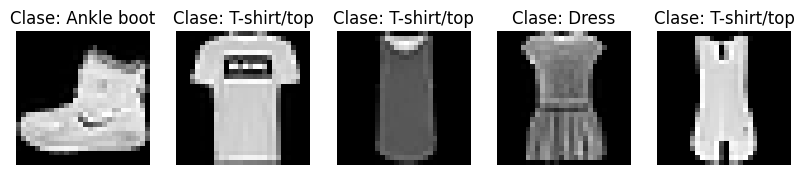

In [ ]:
import matplotlib.pyplot as plt

# Mostrar algunas imágenes
def plot_images(X, y, labels, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[i], cmap="gray")
        plt.title(f"Clase: {labels[y[i]]}")
        plt.axis('off')
    plt.show()

# Etiquetas de las clases
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Visualizar las primeras 5 imágenes
plot_images(X_train, y_train, labels)

## Preprocesamiento de los datos

In [ ]:
# Normalización de las imágenes
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Verificación de la normalización (deberían estar entre 0 y 1)
print("Valor máximo de X_train:", X_train.max())
print("Valor mínimo de X_train:", X_train.min())

Valor máximo de X_train: 1.0
Valor mínimo de X_train: 0.0


In [ ]:
# Redimensionar para que el formato sea (num_samples, 28, 28, 1)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Verificación de la nueva forma
print("Nueva forma de X_train:", X_train.shape)
print("Nueva forma de X_test:", X_test.shape)

Nueva forma de X_train: (60000, 28, 28, 1)
Nueva forma de X_test: (10000, 28, 28, 1)


In [ ]:
from tensorflow.keras.utils import to_categorical

# Codificación one-hot de las etiquetas
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Verificación de la codificación
print("Primeras etiquetas codificadas:", y_train[:5])

Primeras etiquetas codificadas: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# Fase 9: Diseño de la Arquitectura del Modelo CNN

## Definición de la arquitectura de la red convolucional (CNN)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Definir la arquitectura del modelo CNN
model = Sequential()

# Capa convolucional 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))

# Capa convolucional 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Capa convolucional 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Aplanado de la salida
model.add(Flatten())

# Capa densa completamente conectada
model.add(Dense(128, activation='relu'))

# Capa de Dropout para evitar overfitting
model.add(Dropout(0.5))

# Capa de salida (10 clases)
model.add(Dense(10, activation='softmax'))

# Resumen del modelo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

# Fase 10: Entrenamiento del Modelo CNN

## Preparación para el entrenamiento

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Compilación del modelo con la función de pérdida correcta
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


## Definir los Callbacks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Directorios para guardar los modelos y logs
CHECKPOINT_DIR = "/content/drive/MyDrive/Modelo CNN/checkpoints"
LOG_DIR = "/content/drive/MyDrive/Modelo CNN/logs"

# Callback para guardar el mejor modelo
checkpoint_callback = ModelCheckpoint(
    filepath=f"{CHECKPOINT_DIR}/best_model.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Callback para detener el entrenamiento si no hay mejoras
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Número de épocas sin mejora antes de parar
    restore_best_weights=True,
    verbose=1
)

# Callback para TensorBoard
tensorboard_callback = TensorBoard(
    log_dir=LOG_DIR,
    histogram_freq=1,
    write_graph=True
)

## Entrenar el Modelo

In [ ]:
# Entrenamiento del modelo
history_cnn = model.fit(
    X_train, y_train,  # Datos de entrenamiento
    validation_data=(X_test, y_test),  # Datos de validación
    epochs=30,  # Número de épocas
    batch_size=64,  # Tamaño del batch
    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback]
)

Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6417 - loss: 0.9738
Epoch 1: val_loss improved from inf to 0.49951, saving model to /content/drive/MyDrive/Modelo CNN/checkpoints/best_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6418 - loss: 0.9735 - val_accuracy: 0.8081 - val_loss: 0.4995
Epoch 2/30
930/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8245 - loss: 0.4860
Epoch 2: val_loss improved from 0.49951 to 0.40828, saving model to /content/drive/MyDrive/Modelo CNN/checkpoints/best_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8246 - loss: 0.4858 - val_accuracy: 0.8483 - val_loss: 0.4083
Epoch 3/30
927/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8553 - loss: 0.4045
Epoch 3: val_loss improved from 0.40828 to 0.36573, saving model to /content/drive/MyDrive/Modelo CNN/checkpoints/best_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8553 - loss: 0.4044 - val_accuracy: 0.8668 - val_loss: 0.3657
Epoch 4/30
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8683 - loss: 0.3637
Epoch 4: val_loss improved from 0.36573 to 0.34029, saving model to /content/drive/MyDrive/Modelo CNN/checkpoints/best_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8683 - loss: 0.3637 - val_accuracy: 0.8761 - val_loss: 0.3403
Epoch 5/30
926/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8777 - loss: 0.3344
Epoch 5: val_loss did not improve from 0.34029
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8778 - loss: 0.3343 - val_accuracy: 0.8742 - val_loss: 0.3427
Epoch 6/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8891 - loss: 0.3066
Epoch 6: val_loss improved from 0.34029 to 0.32448, saving model to /content/drive/MyDrive/Modelo CNN/checkpoints/best_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8891 - loss: 0.3066 - val_accuracy: 0.8780 - val_loss: 0.3245
Epoch 7/30
934/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8994 - loss: 0.2788
Epoch 7: val_loss improved from 0.32448 to 0.31536, saving model to /content/drive/MyDrive/Modelo CNN/checkpoints/best_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8994 - loss: 0.2788 - val_accuracy: 0.8877 - val_loss: 0.3154
Epoch 8/30
928/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9041 - loss: 0.2619
Epoch 8: val_loss improved from 0.31536 to 0.31226, saving model to /content/drive/MyDrive/Modelo CNN/checkpoints/best_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9041 - loss: 0.2619 - val_accuracy: 0.8890 - val_loss: 0.3123
Epoch 9/30
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9132 - loss: 0.2395
Epoch 9: val_loss improved from 0.31226 to 0.30478, saving model to /content/drive/MyDrive/Modelo CNN/checkpoints/best_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9132 - loss: 0.2396 - val_accuracy: 0.8917 - val_loss: 0.3048
Epoch 10/30
927/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9166 - loss: 0.2284
Epoch 10: val_loss did not improve from 0.30478
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9166 - loss: 0.2284 - val_accuracy: 0.8929 - val_loss: 0.3209
Epoch 11/30
934/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9217 - loss: 0.2132
Epoch 11: val_loss improved from 0.30478 to 0.30063, saving model to /content/drive/MyDrive/Modelo CNN/checkpoints/best_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9217 - loss: 0.2133 - val_accuracy: 0.8952 - val_loss: 0.3006
Epoch 12/30
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9238 - loss: 0.2049
Epoch 12: val_loss did not improve from 0.30063
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9238 - loss: 0.2049 - val_accuracy: 0.8939 - val_loss: 0.3127
Epoch 13/30
928/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9298 - loss: 0.1933
Epoch 13: val_loss did not improve from 0.30063
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9298 - loss: 0.1934 - val_accuracy: 0.8914 - val_loss: 0.3161
Epoch 14/30
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9308 - loss: 0.1836
Epoch 14: val_loss did not improve from 0.30063
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9308 - loss: 0.1837 - val_accuracy: 0.8966 - val_loss: 0.3265
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 11.


# Fase 11: Evaluación del Modelo CNN

## Evaluación del modelo en el conjunto de test

In [ ]:
# Evaluación del modelo en el conjunto de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"📊 Evaluación en test - Accuracy: {test_accuracy:.4f} | Loss: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8931 - loss: 0.3110
📊 Evaluación en test - Accuracy: 0.8952 | Loss: 0.3006


## Análisis de métricas

In [ ]:
from sklearn.metrics import classification_report

# Obtener las predicciones
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convertir probabilidades a clases

# Reporte de clasificación
print("📋 Reporte de Clasificación:\n")
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=labels))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📋 Reporte de Clasificación:

              precision    recall  f1-score   support

 T-shirt/top       0.89      0.78      0.83      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover       0.85      0.83      0.84      1000
       Dress       0.84      0.93      0.88      1000
        Coat       0.82      0.86      0.84      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.70      0.72      0.71      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.98      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## Visualización de resultados

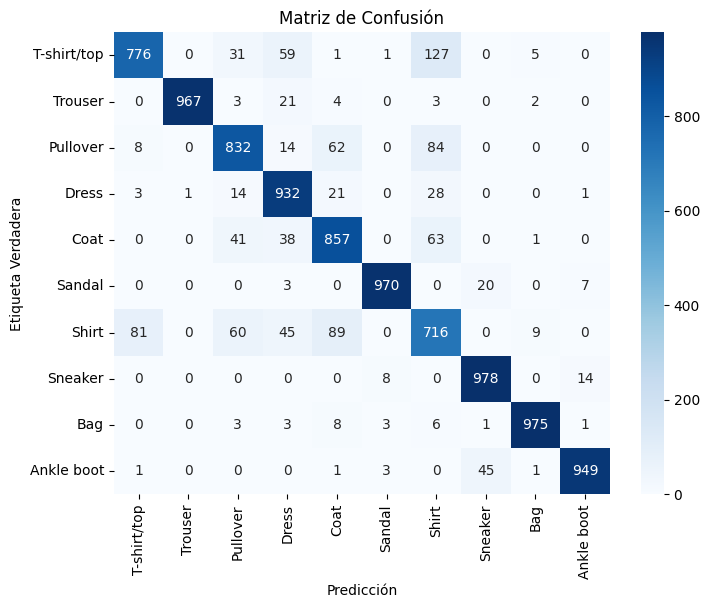

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Verdadera")
plt.title("Matriz de Confusión")
plt.show()

/tmp/ipython-input-24-3940220300.py:11: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


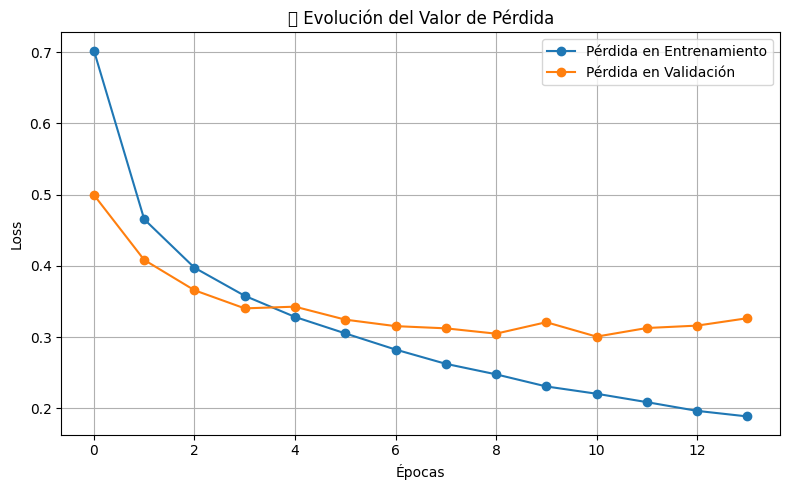

In [ ]:
# Gráfico del valor de pérdida durante el entrenamiento
def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Pérdida en Entrenamiento', marker='o')
    plt.plot(history.history['val_loss'], label='Pérdida en Validación', marker='o')
    plt.title('📉 Evolución del Valor de Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Llamamos a la función para visualizar el gráfico
plot_loss(history_cnn)

# Fase 12: Ajuste de Hiperparámetros y Regularización

## Ajuste de hiperparámetros del modelo

In [ ]:
# Definir la arquitectura del modelo CNN con BatchNormalization
model = Sequential()

# Capa convolucional 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())  # Normalización por lotes
model.add(MaxPooling2D((2, 2)))

# Capa convolucional 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())  # Normalización por lotes
model.add(MaxPooling2D((2, 2)))

# Capa convolucional 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())  # Normalización por lotes
model.add(MaxPooling2D((2, 2)))

# Aplanado de la salida
model.add(Flatten())

# Capa densa completamente conectada
model.add(Dense(128, activation='relu'))

# Capa de Dropout
model.add(Dropout(0.5))

# Capa de salida (10 clases)
model.add(Dense(10, activation='softmax'))

## Regularización

In [ ]:
# Ahora compilamos el modelo después de definir su arquitectura
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Ajustar el learning rate
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Entrenamiento con nuevos parametros

In [ ]:
history_cnn_new = model.fit(
    X_train, y_train,  # Datos de entrenamiento
    validation_data=(X_test, y_test),  # Datos de validación
    epochs=30,  # Número de épocas ajustado
    batch_size=64,  # Tamaño del batch ajustado
    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback]
)

Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7503 - loss: 0.7319
Epoch 1: val_loss did not improve from 0.30063
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.7503 - loss: 0.7317 - val_accuracy: 0.8564 - val_loss: 0.4074
Epoch 2/30
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8615 - loss: 0.3862
Epoch 2: val_loss did not improve from 0.30063
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8615 - loss: 0.3862 - val_accuracy: 0.8474 - val_loss: 0.3981
Epoch 3/30
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8785 - loss: 0.3339
Epoch 3: val_loss did not improve from 0.30063
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8785 - loss: 0.3339 - val_accuracy: 0.8783 - val_loss: 0.3312
Epoch 4/30
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8938 - loss: 0.2932
Epoch 4: val_loss did not improve from 0.30063
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8938 - loss: 0.2933 - val_accuracy: 0.8807 - val_loss: 0.33

# Fase 13: Predicciones y Reporte Final

## Generación de predicciones sobre nuevas imágenes

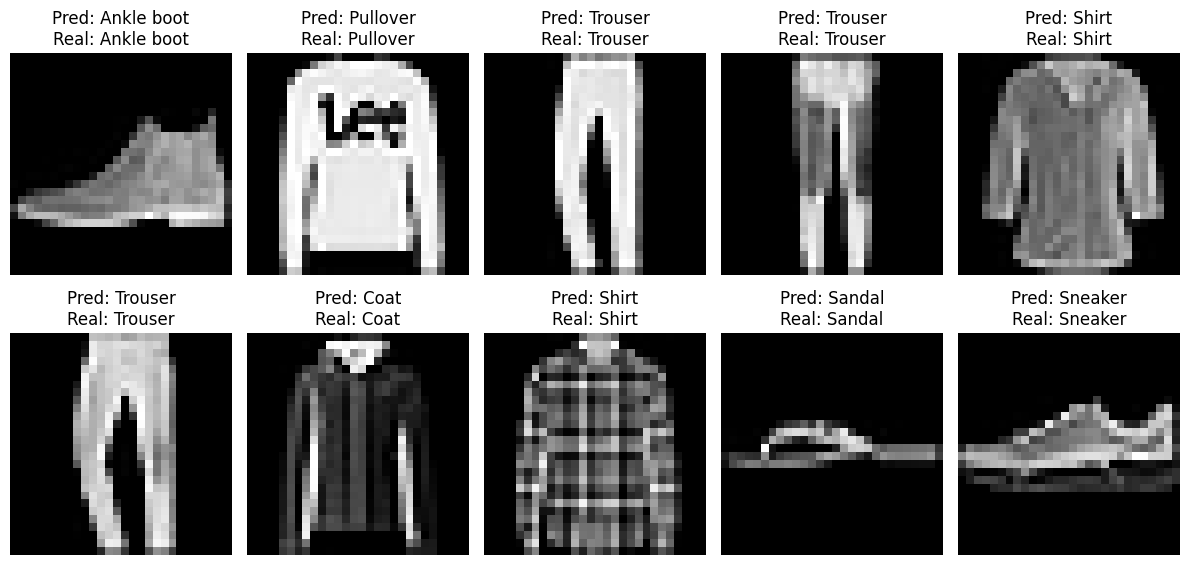

In [ ]:
import matplotlib.pyplot as plt

# Función para mostrar imágenes junto con las predicciones y las clases reales
def plot_images_with_predictions(X, y_true, y_pred, labels, num_images=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)  # 2 filas, 5 columnas
        plt.imshow(X[i].reshape(28, 28), cmap='gray')  # Redimensionamos la imagen a 28x28
        plt.title(f"Pred: {labels[y_pred[i]]}\nReal: {labels[np.argmax(y_true[i])]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Mostrar las primeras 10 imágenes con las predicciones y clases reales
plot_images_with_predictions(X_test, y_test, y_pred, labels, num_images=10)

## Reporte de Clasificación

In [ ]:
from sklearn.metrics import classification_report

# Reporte de clasificación
print("📋 Reporte de Clasificación:\n")
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=labels))

📋 Reporte de Clasificación:

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.86      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.76      0.87      0.81      1000
       Dress       0.87      0.90      0.88      1000
        Coat       0.87      0.70      0.78      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.68      0.64      0.66      1000
     Sneaker       0.92      0.97      0.94      1000
         Bag       0.96      0.97      0.97      1000
  Ankle boot       0.97      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Matriz de Confusión

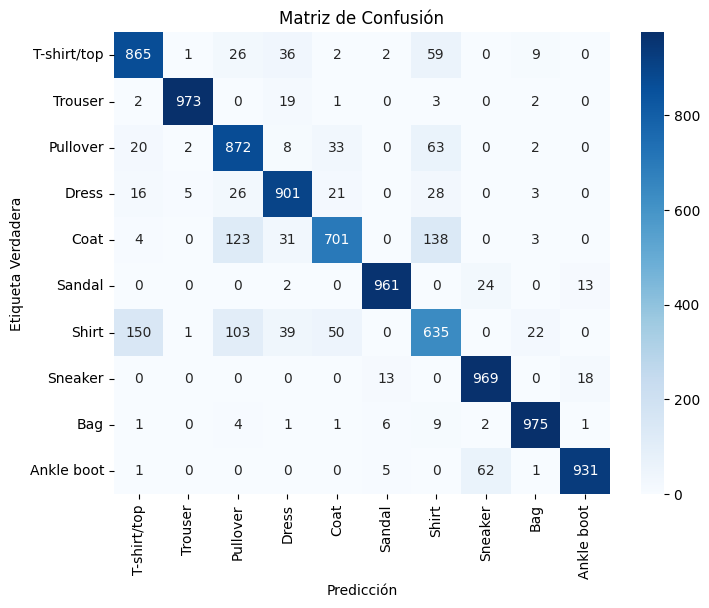

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Verdadera")
plt.title("Matriz de Confusión")
plt.show()

## Gráfico de la Evolución de la Pérdida

/tmp/ipython-input-38-1574992072.py:11: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


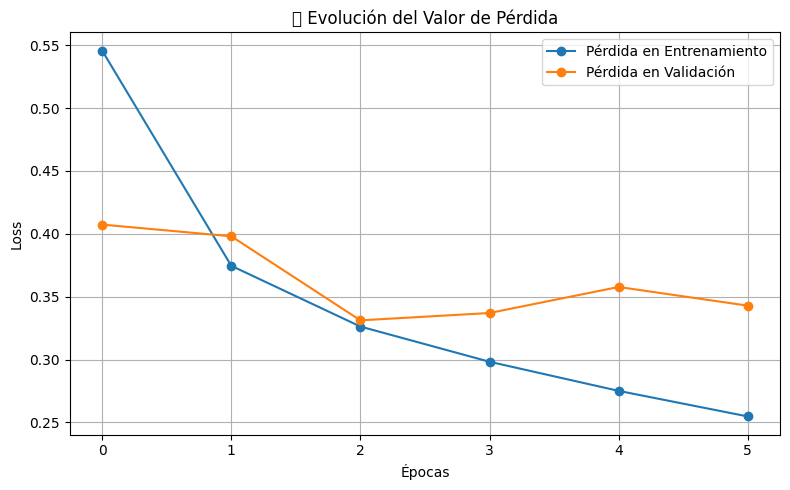

In [ ]:
# Gráfico del valor de pérdida durante el entrenamiento
def plot_loss(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Pérdida en Entrenamiento', marker='o')
    plt.plot(history.history['val_loss'], label='Pérdida en Validación', marker='o')
    plt.title('📉 Evolución del Valor de Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Llamamos a la función para visualizar el gráfico
plot_loss(history_cnn_new)

## Guardar modelo final

In [ ]:
# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/Modelo CNN/modelo/fashion_mnist_cnn_model.h5')

print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


## Codigo para carga modelo guardado (Solo referencial)

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el modelo previamente guardado
loaded_model = load_model('/content/drive/MyDrive/Modelo CNN/modelo/fashion_mnist_cnn_model.h5')

print("Modelo cargado exitosamente.")

# Fase 14: Evaluación con imagenes reales por usuario

## Implementación Gradio

In [ ]:
pip install gradio

In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

# Cargar el modelo guardado
model = load_model('/content/drive/MyDrive/Modelo CNN/modelo/fashion_mnist_cnn_model.h5')

# Función para preprocesar la imagen y hacer la predicción
def predict_image(img):
    try:
        # Verificar si la entrada es None
        if img is None:
            return "Error: No se ha proporcionado ninguna imagen"

        # Convertir a PIL Image si es necesario
        if isinstance(img, np.ndarray):
            # Si es un array numpy, convertirlo a PIL Image
            img = Image.fromarray(img.astype('uint8'))

        # Convertir a escala de grises
        if img.mode != 'L':
            img = img.convert('L')

        # Redimensionar a 28x28 píxeles
        img = img.resize((28, 28), Image.Resampling.LANCZOS)

        # Convertir a array numpy
        img_array = np.array(img)

        # Verificar el tamaño del array
        print(f"Tamaño de la imagen procesada: {img_array.shape}")

        # Normalizar la imagen a escala [0, 1]
        img_array = img_array.astype('float32') / 255.0

        # Añadir dimensiones para el modelo: (1, 28, 28, 1)
        img_array = np.expand_dims(img_array, axis=-1)  # (28, 28, 1)
        img_array = np.expand_dims(img_array, axis=0)   # (1, 28, 28, 1)

        # Verificar que la forma del array es la correcta
        print(f"Forma del array para el modelo: {img_array.shape}")

        # Realizar la predicción
        prediction = model.predict(img_array, verbose=0)

        # Obtener la clase con la mayor probabilidad
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)

        # Etiquetas de las clases
        labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

        # Retornar el resultado con confianza
        return f"Predicción: {labels[predicted_class]} (Confianza: {confidence:.2%})"

    except Exception as e:
        return f"Error al procesar la imagen: {str(e)}"

# Crear la interfaz con Gradio
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),  # Usar type="pil" para recibir PIL Image
    outputs=gr.Text(),
    title="Clasificador Fashion-MNIST CNN",
    description="Sube una imagen de una prenda de vestir y el modelo predecirá qué tipo de prenda es.",
    examples=None  # Puedes agregar ejemplos aquí si tienes imágenes de prueba
)

# Lanzar la interfaz
if __name__ == "__main__":
    interface.launch(debug=True)

# Fase 15: Fusionar Modelos

Cargar los modelos ya entrenados

In [4]:
from google.colab import drive
from tensorflow.keras.models import load_model
import os

drive.mount('/content/drive')

def check_model_loaded(model, model_name):
    try:
        model.summary()
        print(f"{model_name} ✅")
    except Exception as e:
        print(f"{model_name} ❌ - Error: {str(e)}")

cnn_model_path = '/content/drive/My Drive/fashion_mnist_cnn_model.h5'
transformer_model_path = '/content/drive/My Drive/best_model.h5'

if os.path.exists(cnn_model_path):
    try:
        cnn_model = load_model(cnn_model_path)
        check_model_loaded(cnn_model, "CNN Model")
    except Exception as e:
        print(f"CNN Model ❌ - Error al cargar el modelo: {str(e)}")
else:
    print(f"CNN Model ❌ - No se encontró el archivo en {cnn_model_path}")

if os.path.exists(transformer_model_path):
    try:
        transformer_model = load_model(transformer_model_path)
        check_model_loaded(transformer_model, "Transformer Model")
    except Exception as e:
        print(f"Transformer Model ❌ - Error al cargar el modelo: {str(e)}")
else:
    print(f"Transformer Model ❌ - No se encontró el archivo en {transformer_model_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,372 (435.05 KB)

 Trainable params: 110,922 (433.29 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

CNN Model ✅


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,476 (431.55 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Transformer Model ✅


Visualizar la Distribución de Clases

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


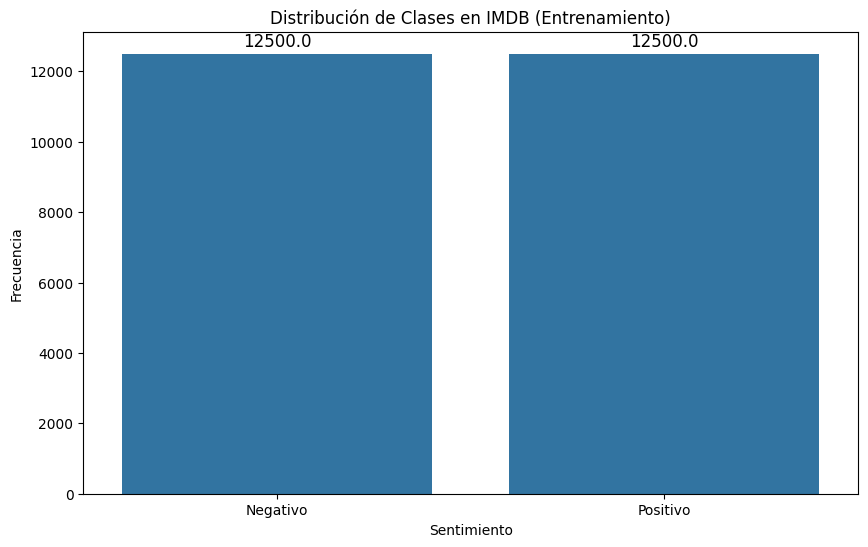

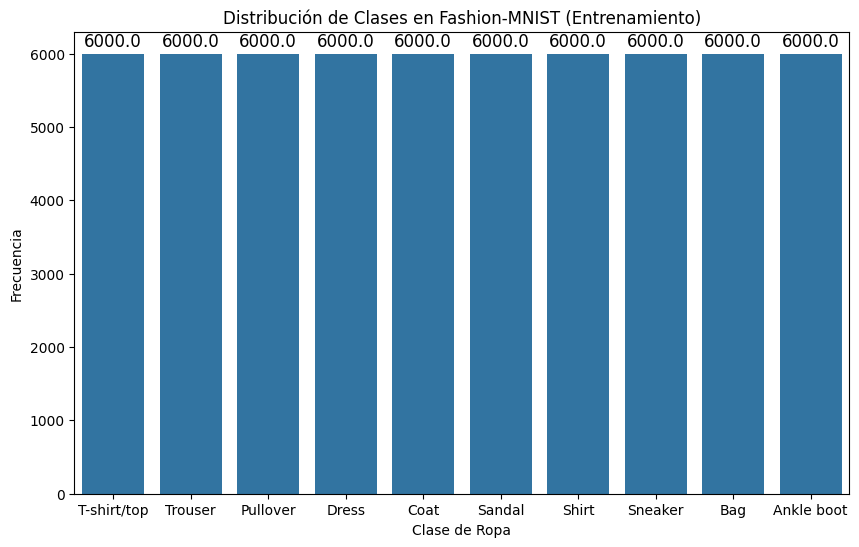

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.datasets import imdb, fashion_mnist

# Reload the datasets to get original labels
(X_train_imdb, y_train_imdb), (X_test_imdb, y_test_imdb) = imdb.load_data(num_words=10000)
(X_train_fashion, y_train_fashion), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()

# Visualización del desbalance de clases en IMDB
plt.figure(figsize=(10, 6))

# Contar las clases de IMDB
ax = sns.countplot(x=y_train_imdb)  # y_train_imdb are the original IMDB labels (0 or 1)
plt.title("Distribución de Clases en IMDB (Entrenamiento)")
plt.xlabel("Sentimiento")
plt.ylabel("Frecuencia")
plt.xticks([0, 1], ['Negativo', 'Positivo'])

# Añadir los valores encima de las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 9), textcoords='offset points')

plt.show()

# Visualización del desbalance de clases en Fashion-MNIST
plt.figure(figsize=(10, 6))

# Contar las clases de Fashion-MNIST (etiquetas de 0 a 9)
ax = sns.countplot(x=y_train_fashion)  # y_train_fashion are the original Fashion-MNIST labels
plt.title("Distribución de Clases en Fashion-MNIST (Entrenamiento)")
plt.xlabel("Clase de Ropa")
plt.ylabel("Frecuencia")
plt.xticks(np.arange(10), ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

# Añadir los valores encima de las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 9), textcoords='offset points')

plt.show()

Reducción de la Arquitectura del Modelo y Fusión


In [6]:
from tensorflow.keras.layers import Input, Concatenate, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling1D, MultiHeadAttention, LayerNormalization, Embedding
from tensorflow.keras.models import Model

# Parámetros
MAX_LEN = 250
EMBED_DIM = 128
NUM_HEADS = 4
FF_DIM = 128
NUM_ENCODER_BLOCKS = 2
NUM_DECODER_BLOCKS = 2
DROPOUT_RATE = 0.3  # Aumentamos el dropout para evitar sobreajuste
VOCAB_SIZE = 10000
NUM_CLASSES_CNN = 10  # Número de clases en Fashion-MNIST

# Definir las entradas
image_input = Input(shape=(28, 28, 1), name="image_input")  # Dimensiones de las imágenes
text_input = Input(shape=(MAX_LEN,), name="text_input")  # Longitud de las secuencias de texto

# --- CNN (Imágenes de Fashion-MNIST) ---
cnn_x = Conv2D(32, (3, 3), activation='relu')(image_input)
cnn_x = BatchNormalization()(cnn_x)
cnn_x = MaxPooling2D((2, 2))(cnn_x)

cnn_x = Conv2D(64, (3, 3), activation='relu')(cnn_x)
cnn_x = BatchNormalization()(cnn_x)
cnn_x = MaxPooling2D((2, 2))(cnn_x)

cnn_x = Conv2D(128, (3, 3), activation='relu')(cnn_x)
cnn_x = BatchNormalization()(cnn_x)
cnn_x = MaxPooling2D((2, 2))(cnn_x)

cnn_x = Flatten()(cnn_x)
cnn_x = Dense(128, activation='relu')(cnn_x)
cnn_output_features = Dropout(DROPOUT_RATE)(cnn_x)  # Dropout para regularizar

# --- Transformer (Texto IMDB) ---
embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN, mask_zero=True)
x_enc = embedding_layer(text_input)
x_dec = embedding_layer(text_input)  # Decoder input es también la secuencia de texto

def transformer_encoder(inputs):
    attention = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)(inputs, inputs)
    attention = Dropout(DROPOUT_RATE)(attention)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attention)
    ff = Dense(FF_DIM, activation="relu")(out1)
    ff = Dense(EMBED_DIM)(ff)
    ff = Dropout(DROPOUT_RATE)(ff)
    return LayerNormalization(epsilon=1e-6)(out1 + ff)

def transformer_decoder(inputs, encoder_output):
    attention1 = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)(inputs, inputs)
    attention1 = Dropout(DROPOUT_RATE)(attention1)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attention1)
    attention2 = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)(out1, encoder_output)
    attention2 = Dropout(DROPOUT_RATE)(attention2)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + attention2)
    ff = Dense(FF_DIM, activation="relu")(out2)
    ff = Dense(EMBED_DIM)(ff)
    ff = Dropout(DROPOUT_RATE)(ff)
    return LayerNormalization(epsilon=1e-6)(out2 + ff)

# Apply encoder and decoder blocks
x_enc_rebuilt = x_enc
for _ in range(NUM_ENCODER_BLOCKS):
    x_enc_rebuilt = transformer_encoder(x_enc_rebuilt)

x_dec_rebuilt = x_dec
for _ in range(NUM_DECODER_BLOCKS):
    x_dec_rebuilt = transformer_decoder(x_dec_rebuilt, x_enc_rebuilt)

transformer_output_features = GlobalAveragePooling1D()(x_dec_rebuilt)
transformer_output_features = Dropout(DROPOUT_RATE)(transformer_output_features)

# --- Fusión de los Modelos ---
merged = Concatenate()([cnn_output_features, transformer_output_features])

# --- Capa Final de Clasificación ---
final_output = Dense(1, activation='sigmoid', name="final_output")(merged)

# --- Crear el modelo fusionado ---
final_model = Model(inputs=[image_input, text_input], outputs=final_output)

# --- Compilar el modelo final ---
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- Resumen del modelo fusionado ---
final_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 250)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 250, 128)  │  1,280,000 │ text_input[0][0], │
│ (Embedding)         │                   │            │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 250)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 250, 128)  │    263,808 │ embedding[0][0],  │
│ (MultiHeadAttentio… │                   │            │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 250, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 250, 128)  │          0 │ embedding[0][0],  │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 250, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 250, 128)  │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 250, 128)  │     16,512 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 250, 128)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 250, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 250, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 250, 128)  │    263,808 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 250, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 250, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 250, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 250)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 250, 128)  │     16,512 │ layer_normalizat

 Total params: 3,107,841 (11.86 MB)

 Trainable params: 3,107,393 (11.85 MB)

 Non-trainable params: 448 (1.75 KB)

# Fase 16: Entrenamiento del Modelo

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6400 - loss: 0.9881
Epoch 1: val_loss improved from inf to 0.48750, saving model to /content/drive/MyDrive/fusion/fusion.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6401 - loss: 0.9878 - val_accuracy: 0.8229 - val_loss: 0.4875
Epoch 2/30
929/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8261 - loss: 0.4834
Epoch 2: val_loss improved from 0.48750 to 0.43079, saving model to /content/drive/MyDrive/fusion/fusion.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8262 - loss: 0.4832 - val_accuracy: 0.8439 - val_loss: 0.4308
Epoch 3/30
927/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8545 - loss: 0.4063
Epoch 3: val_loss improved from 0.43079 to 0.35948, saving model to /content/drive/MyDrive/fusion/fusion.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8545 - loss: 0.4062 - val_accuracy: 0.8696 - val_loss: 0.3595
Epoch 4/30
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8705 - loss: 0.3614
Epoch 4: val_loss improved from 0.35948 to 0.34928, saving model to /content/drive/MyDrive/fusion/fusion.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8705 - loss: 0.3614 - val_accuracy: 0.8716 - val_loss: 0.3493
Epoch 5/30
933/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8859 - loss: 0.3228
Epoch 5: val_loss improved from 0.34928 to 0.32481, saving model to /content/drive/MyDrive/fusion/fusion.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8859 - loss: 0.3228 - val_accuracy: 0.8837 - val_loss: 0.3248
Epoch 6/30
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8908 - loss: 0.3015
Epoch 6: val_loss improved from 0.32481 to 0.31500, saving model to /content/drive/MyDrive/fusion/fusion.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8909 - loss: 0.3015 - val_accuracy: 0.8816 - val_loss: 0.3150
Epoch 7/30
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8990 - loss: 0.2815
Epoch 7: val_loss did not improve from 0.31500
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8990 - loss: 0.2815 - val_accuracy: 0.8858 - val_loss: 0.3164
Epoch 8/30
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9052 - loss: 0.2625
Epoch 8: val_loss improved from 0.31500 to 0.29952, saving model to /content/drive/MyDrive/fusion/fusion.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9052 - loss: 0.2625 - val_accuracy: 0.8914 - val_loss: 0.2995
Epoch 9/30
931/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9124 - loss: 0.2410
Epoch 9: val_loss did not improve from 0.29952
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9123 - loss: 0.2410 - val_accuracy: 0.8874 - val_loss: 0.3159
Epoch 10/30
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9155 - loss: 0.2348
Epoch 10: val_loss did not improve from 0.29952
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9155 - loss: 0.2348 - val_accuracy: 0.8929 - val_loss: 0.3040
Epoch 11/30
932/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9226 - loss: 0.2112
Epoch 11: val_loss did not improve from 0.29952
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9226 - loss: 0.2112 - val_accuracy: 0.8943 - val_loss: 0.3075
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 8.


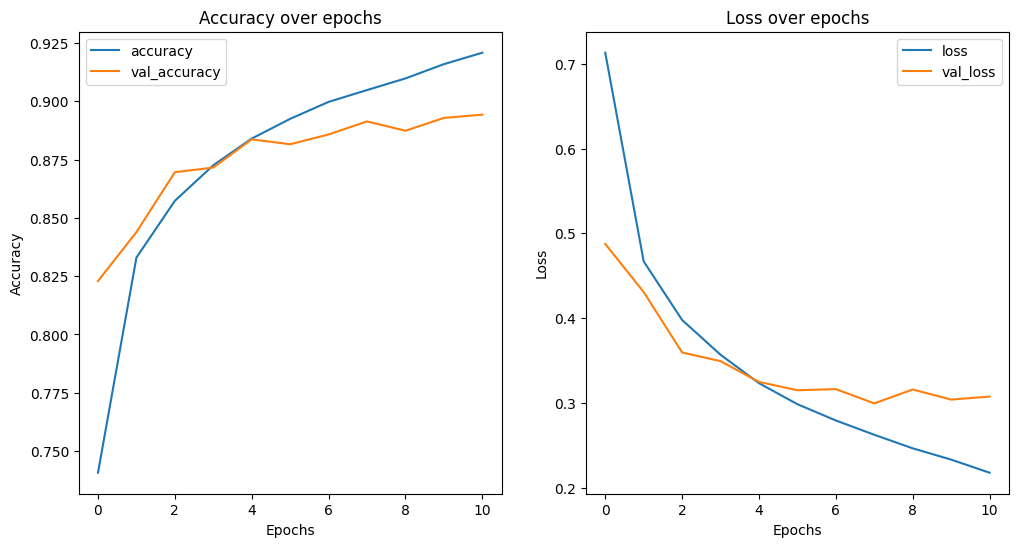

In [9]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
from google.colab import drive
import os

# Montar Google Drive
drive.mount('/content/drive')

# Ruta en Google Drive donde se guardará el modelo
checkpoint_dir = '/content/drive/MyDrive/fusion'
os.makedirs(checkpoint_dir, exist_ok=True)

# Cargar y preprocesar los datos
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalizar las imágenes a valores entre 0 y 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Redimensionar para que tengan un canal único (grayscale)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Codificar las etiquetas a formato one-hot
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Crear el modelo CNN
model = Sequential()

# Capa 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))

# Capa 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Capa 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Aplanado de la salida
model.add(Flatten())

# Capa densa
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout para evitar sobreajuste

# Capa de salida (10 clases)
model.add(Dense(10, activation='softmax'))

# Compilamos el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callback para guardar el mejor modelo en Google Drive
checkpoint_callback = ModelCheckpoint(
    os.path.join(checkpoint_dir, 'fusion.h5'),
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Callback para detener el entrenamiento si no hay mejora
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Callback para TensorBoard
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Entrenamos el modelo
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback])

# Visualizamos la precisión y la pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Fase 17: Evaluación del Modelo y Matriz de Confusión

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8974 - loss: 0.3096
Test Accuracy: 0.8954
Test Loss: 0.2932
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


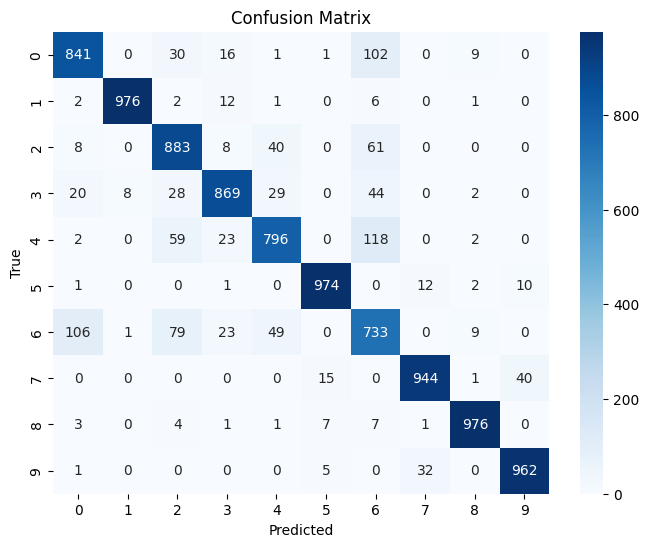

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Cargar el mejor modelo guardado
model.load_weights('/content/drive/MyDrive/fusion/fusion_best_model.h5')

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predecir las clases en el conjunto de test
y_pred = model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()
y_true_classes = tf.argmax(y_test, axis=1).numpy()

# Generar la matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Fase 18: Gradio para el modelo de análisis de sentimiento (Transformer)

In [1]:
pip install --upgrade gradio

In [2]:
import gradio as gr
import numpy as np

# Función para hacer predicciones con el modelo
def predict_image(image):
    # Convertir la imagen a un array de numpy
    image = np.array(image)

    # Asegurarse de que la imagen tenga la forma adecuada para el modelo
    image = np.expand_dims(image, axis=-1)  # Para asegurar un solo canal (grayscale)
    image = image.astype('float32') / 255.0  # Normalizar la imagen a valores entre 0 y 1
    image = np.expand_dims(image, axis=0)  # Añadir la dimensión del batch (1, 28, 28, 1)

    # Predecir usando el modelo (asumiendo que ya tienes un modelo entrenado)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)  # Obtener la clase con la mayor probabilidad
    return f"Predicted Class: {predicted_class}"

# Interfaz de Gradio (actualizada)
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(image_mode='L', size=(28, 28)),  # Usamos 'size' en lugar de 'shape'
    outputs='text'
)

interface.launch()


TypeError: Image.__init__() got an unexpected keyword argument 'size'